# **Importing necessary libraries and modules**

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)


**Connecting to the drive to acces the data**

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the data
The data was preprocessed and stored on the drive for easier accesibility


*   preprocessed_train_data is the data collected for the iperf ran for the duration of 10,20,30,40 Seconds
*   preprocessed_val_data is the data collected for the iperf ran for the duration of 50 Seconds.
*   preprocessed_test_data is the data collected for the iperf ran for the duration of 60 Seconds.
*   preprocessed_train_val_data is a combination of both train and validation sets

In [3]:
DATAPATH = '/content/gdrive/My Drive/Data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
print(train_all_dataset.shape)
print(test_dataset.shape)

(1584, 6)
(392, 6)
(1976, 6)
(391, 6)


**Bringing in mew data**

In [4]:
New_data = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_10s.txt')
New_data1 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_20s.txt')
New_data2 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_30s.txt')
New_data3 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_40s.txt')
New_data4 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_50s.txt')
New_data5 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_60s.txt')

**Below are a few data-preprocessing steps to combine old_data with new_data**

In [5]:
datasets = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]

In [6]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [8]:
# Operation to only keep the needed columns / features for the models
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [9]:
# Adding a duration column to the new_data
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df, duration in zip(data_frames, range(10, 70, 10)):
    df['Duration'] = duration
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Transfer': 'Transferred Traffic (KBytes)'}, inplace=True)

In [10]:
# Changing the transffered data into MBytes (for data transffered for 10s)
New_data['Transferred Traffic (KBytes)'] = New_data['Transferred Traffic (KBytes)'] / 1024

In [11]:
# Combining the first 4 new datasets which will be added to the test_set
combined_New_data = pd.concat([New_data, New_data1, New_data2, New_data3], ignore_index=True)
combined_New_data.reset_index(drop=True, inplace=True)

In [12]:
# Making some spelling correction in the old data
old_data_frames = [train_dataset, val_dataset, test_dataset, train_all_dataset]
for df in old_data_frames:
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Tranfered Trafic (KBytes)': 'Transferred Traffic (KBytes)'}, inplace=True)

In [13]:
# Defining the columns / features to keep in our old dataset
columns_to_keep = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']
train_dataset = train_dataset[columns_to_keep]
val_dataset = val_dataset[columns_to_keep]
test_dataset = test_dataset[columns_to_keep]

In [14]:
# Combining the old dataset with the new dataset
New_train_data = pd.concat([train_dataset, combined_New_data], ignore_index=True)
New_val_data = pd.concat([val_dataset, New_data4], ignore_index=True)
New_test_data = pd.concat([test_dataset, New_data5], ignore_index=True)


In [15]:
# Selecting out data to make re-arrangements in it
df_10 = New_train_data[New_train_data['Duration'] == 10]
df_20 = New_train_data[New_train_data['Duration'] == 20]
df_30 = New_train_data[New_train_data['Duration'] == 30]
df_40 = New_train_data[New_train_data['Duration'] == 40]

In [16]:
train_data_final = pd.concat([df_10, df_20, df_30, df_40], ignore_index=True)

In [17]:
train_data_final_all = pd.concat([train_data_final, New_val_data], ignore_index=True)

In [18]:
# checkinging the data
train_data_final.head(4700)

,Bandwidth (Mbits/sec),Duration,Transferred Traffic (KBytes)
0,12.60,10,0.750000
1,12.60,10,0.750977
2,10.50,10,0.625000
3,8.39,10,0.500000
4,10.50,10,0.625000
...,...,...,...
4695,9.96,40,2.380000
4696,9.96,40,2.380000
4697,9.96,40,2.380000
4698,9.96,40,2.380000


In [19]:
# checking
train_data_final_all.head(5000)

,Bandwidth (Mbits/sec),Duration,Transferred Traffic (KBytes)
0,12.60,10,0.750000
1,12.60,10,0.750977
2,10.50,10,0.625000
3,8.39,10,0.500000
4,10.50,10,0.625000
...,...,...,...
4995,10.10,50,3.000000
4996,10.10,50,3.000000
4997,10.10,50,3.000000
4998,10.10,50,3.000000


## Extracting and normalising the features

The files I have read in are pandas dataframes, containing a wide range of possibly useful features. Now I will perform these steps

1. Extract the features I'll want to use.
2. Train and apply a scaler to the feature matrices.

Starting with extracting the features.

In [20]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transffered Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(feature_matrix(train_data_final,features),dtype=np.float32)
train_labels = np.asarray(train_data_final['Transferred Traffic (KBytes)'],dtype=np.float32)

val_values = np.asarray(feature_matrix(New_val_data,features),dtype=np.float32)
val_labels = np.asarray(New_val_data['Transferred Traffic (KBytes)'],dtype=np.float32)

# data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_data_final_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_data_final_all['Transferred Traffic (KBytes)'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(New_test_data,features),dtype=np.float32)
test_labels = np.asarray(New_test_data['Transferred Traffic (KBytes)'],dtype=np.float32)



# checking
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)



(4701, 3)
(4701,)
(1172, 3)
(1172,)
(5873, 3)
(5873,)
(1171, 3)
(1171,)


In [21]:
from sklearn.preprocessing import StandardScaler
SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# Training and applying scaler for test features

SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

In [22]:
# window-based and recurrent networks:
# making predictions seconds ahead. NB: 8 = 4seconds ....
# for now the window size is set to 1

def create_dataset_windowed(features, labels, ahead=8, window_size=1, max_window_size=1):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]



## Simplest sandbox model

The simplest sandbox model I designed just uses the current Transfered traffic to predict the transfered traffic of 4 seconds ahead. In the code below, I create these predictions, and evaluate them, using a 'Plotresults' function.

I extract the labels and the predictions using the functions defined above. I as well apply np.squeeze function for removing unnecessary dimensions from the arrays.
https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html


The results obtained show a pretty close match between all scores.

In [23]:
# I apply current Transferred traffic as prediction
# Since I do not need Tensorflow for this, I will simply use the corresponding loss function from sklearn

from sklearn.metrics import mean_absolute_error

# NOTE: since there is no model involved, no scaler is used here.

train_throughput = np.asarray(feature_matrix(train_data_final,['Transferred Traffic (KBytes)',]),dtype=np.float32)
val_throughput = np.asarray(feature_matrix(New_val_data,['Transferred Traffic (KBytes)',]),dtype=np.float32)

train_all_throughput = np.asarray(feature_matrix(train_data_final_all,['Transferred Traffic (KBytes)',]),dtype=np.float32)
test_throughput = np.asarray(feature_matrix(New_test_data,['Transferred Traffic (KBytes)',]),dtype=np.float32)

X0_train,r0_train = create_dataset_windowed(train_throughput,train_labels)
X0_val,r0_val = create_dataset_windowed(val_throughput,val_labels)

X0_train_all,r0_train_all = create_dataset_windowed(train_all_throughput,train_all_labels)
X0_test,r0_test = create_dataset_windowed(test_throughput,test_labels)

y0_train = np.squeeze(X0_train)
y0_val = np.squeeze(X0_val)

y0_train_all = np.squeeze(X0_train_all)
y0_test = np.squeeze(X0_test)
y0_train = y0_train.reshape(-1, 1)
mae_train_current = mean_absolute_error(r0_train,y0_train)
mae_val_current = mean_absolute_error(r0_val,y0_val)

mae_train_all_current = mean_absolute_error(r0_train_all,y0_train_all)
mae_test_current = mean_absolute_error(r0_test,y0_test)

print("\"Current Network throughput\" baseline:\n train mae = ",mae_train_current,
      "\n validation mae = ",mae_val_current)

print("\"Current Network throughput\" baseline:\n train+validation mae = ",mae_train_all_current,
     "\n test mae = ",mae_test_current)

"Current Network throughput" baseline:
 train mae =  0.048529327 
 validation mae =  0.04350512
"Current Network throughput" baseline:
 train+validation mae =  0.048291232 
 test mae =  0.090283684


How to visualise the results.

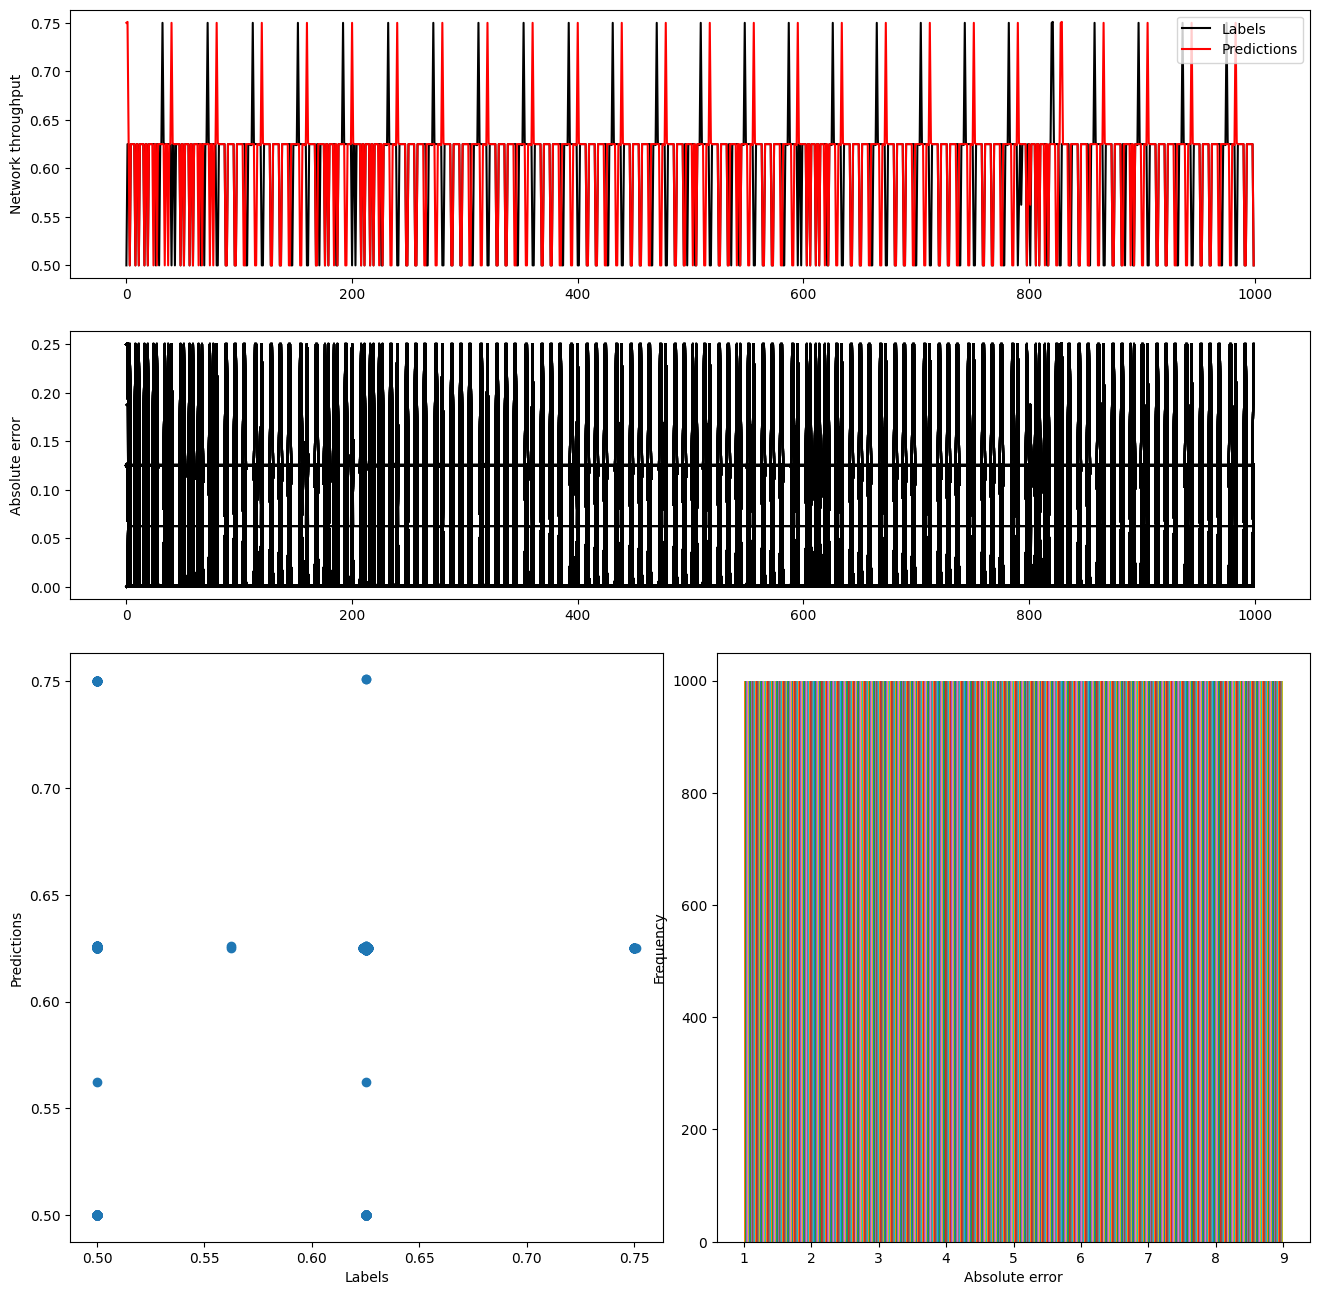

In [24]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)

  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])

  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Network throughput')
  ax1.legend()

  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")

  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)

  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualising the first 1000 predictions
PlotResults(r0_train[:1000],y0_train[:1000])

In [ ]:
# checking
print(train_scaled.shape)
print(train_labels.shape)
print(val_scaled.shape)
print(val_labels.shape)

(4701, 3)
(4701,)
(1172, 3)
(1172,)


## **Building models**

In [25]:
# Stage 1 model: Model only using current features for prediction
# Starting from the scaled datasets extracted above: train_scaled and val_scaled
# First, converting the data into the right format for the LSTM network and applyin the create_dataset_windowed function (as demonstrated before)

X_train_dense,r_train_dense = create_dataset_windowed(train_scaled,train_labels)
X_train_dense = np.squeeze(X_train_dense)
X_val_dense,r_val_dense = create_dataset_windowed(val_scaled,val_labels)
X_val_dense = np.squeeze(X_val_dense)

print(X_train_dense.shape)
print(r_train_dense.shape)
print(X_val_dense.shape)
print(r_val_dense.shape)

(4693, 3)
(4693,)
(1164, 3)
(1164,)


In [26]:
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [27]:
from keras.callbacks import LearningRateScheduler
from keras.layers import GRU
def create_model(input_shape):

    # Initializing the Sequential model
    model = Sequential()

    # Adding layers to the model
    model.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    # Compiling the model
    model.compile(optimizer=Nadam(lr=0.0001), loss='mae')

    # Returning the model
    return model

In [28]:
LSTM_model = create_model((3,1))
LSTM_history = LSTM_model.fit(X_train_dense, r_train_dense, epochs=30, batch_size=64, validation_data=(X_val_dense, r_val_dense))


Epoch 1/30
74/74 [==============================] - 22s 52ms/step - loss: 58.0364 - val_loss: 25.1220
Epoch 2/30
74/74 [==============================] - 1s 19ms/step - loss: 15.3112 - val_loss: 10.1999
Epoch 3/30
74/74 [==============================] - 1s 18ms/step - loss: 6.7120 - val_loss: 5.8976
Epoch 4/30
74/74 [==============================] - 1s 18ms/step - loss: 3.9338 - val_loss: 4.0918
Epoch 5/30
74/74 [==============================] - 1s 18ms/step - loss: 2.4931 - val_loss: 3.3604
Epoch 6/30
74/74 [==============================] - 1s 18ms/step - loss: 1.9088 - val_loss: 2.7715
Epoch 7/30
74/74 [==============================] - 1s 20ms/step - loss: 1.4506 - val_loss: 2.2989
Epoch 8/30
74/74 [==============================] - 2s 24ms/step - loss: 1.1598 - val_loss: 2.0147
Epoch 9/30
74/74 [==============================] - 2s 22ms/step - loss: 0.9394 - val_loss: 1.6711
Epoch 10/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7681 - val_loss: 1.4949
Epoc

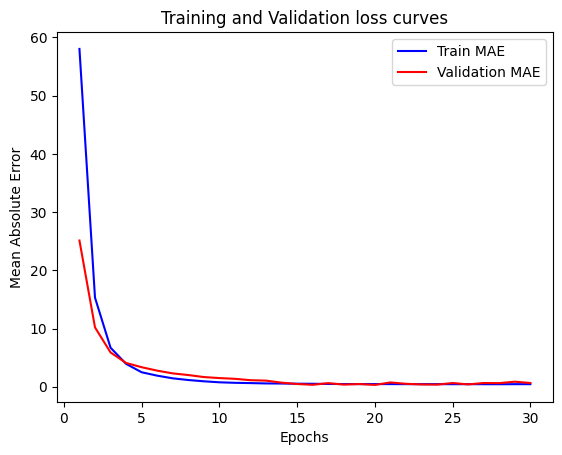

In [29]:
train_loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Training and Validation loss curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
print(X_train_dense.shape)
print(X_val_dense.shape)

(4693, 3)
(1164, 3)


37/37 [==============================] - 0s 9ms/step
"Current Network throuput" baseline:
 train mae =  0.28088668 
 validation mae =  0.36678055
(4693, 1)
(1164, 1)


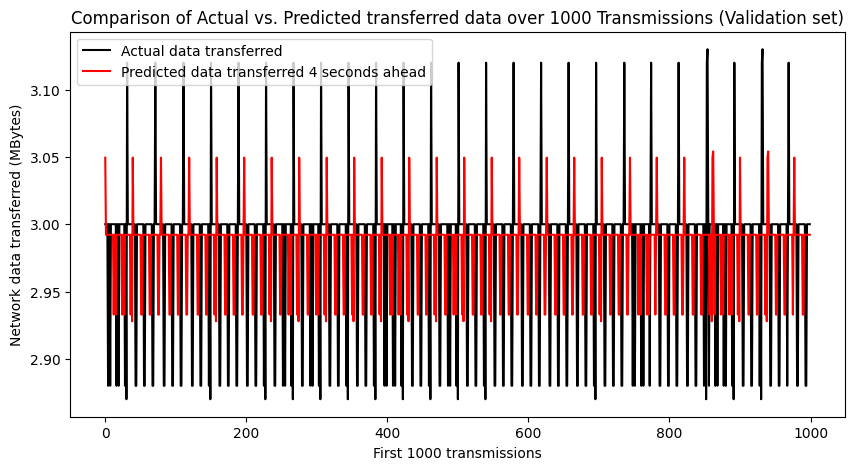

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Making predictions using the trained model
y_train_LSTM = LSTM_model.predict(X_train_dense)
y_val_LSTM = LSTM_model.predict(X_val_dense)

# Calculating the mean absolute error from the training and validation sets
mae_train_LSTM = mean_absolute_error(r_train_dense, y_train_LSTM)
mae_val_LSTM = mean_absolute_error(r_val_dense, y_val_LSTM)

# Printing the mean absolute error from the training and validation sets
print("\"Current Network throuput\" baseline:\n train mae = ", mae_train_LSTM,
      "\n validation mae = ", mae_val_LSTM)

# Printing the shapes of the predicted output from the training and val sets
print(y_train_LSTM.shape)
print(y_val_LSTM.shape)

# Visualising first 1000 predictions from the validation set
def scale_predictions_to_labels(labels, predictions):
    scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions * scale_factor
    return scaled_predictions

# Apply the scaling function
scaled_predictions = scale_predictions_to_labels(r_val_dense[:1000], y_val_LSTM[:1000, 0])

# Now plot the labels and scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(r_val_dense[:1000], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:1000], 'r-', label='Predicted data transferred 4 seconds ahead')  # Ensure predictions are also limited to first 300 for plotting
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 1000 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 1000 Transmissions (Validation set)')  # Adding a title for context
plt.legend()
plt.show()

**We try to see how a GRU performs**

In [31]:
from keras.callbacks import LearningRateScheduler
from keras.layers import GRU
def create_model_GRU(input_shape):

    # Initializing the Sequential model
    modelGRU = Sequential()

    # Adding layers to the model
    modelGRU.add(Bidirectional(GRU(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    modelGRU.add(BatchNormalization())
    modelGRU.add(Dropout(0.5))

    modelGRU.add(Bidirectional(GRU(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    modelGRU.add(BatchNormalization())
    modelGRU.add(Dropout(0.5))

    modelGRU.add(Bidirectional(GRU(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    modelGRU.add(BatchNormalization())
    modelGRU.add(Dropout(0.5))

    modelGRU.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    modelGRU.add(BatchNormalization())
    modelGRU.add(Dropout(0.5))

    modelGRU.add(Dense(1, activation='linear'))

    # Compiling the model
    modelGRU.compile(optimizer=Nadam(lr=0.0001), loss='mae')

    # Returning the model
    return modelGRU

In [32]:
GRU_model = create_model_GRU((3,1))
GRU_history = GRU_model.fit(X_train_dense, r_train_dense, epochs=30, batch_size=64, validation_data=(X_val_dense, r_val_dense))

Epoch 1/30
74/74 [==============================] - 20s 52ms/step - loss: 53.5011 - val_loss: 27.1880
Epoch 2/30
74/74 [==============================] - 2s 32ms/step - loss: 17.8825 - val_loss: 12.7315
Epoch 3/30
74/74 [==============================] - 2s 32ms/step - loss: 8.6790 - val_loss: 7.2944
Epoch 4/30
74/74 [==============================] - 3s 41ms/step - loss: 5.0213 - val_loss: 5.2471
Epoch 5/30
74/74 [==============================] - 2s 24ms/step - loss: 3.4885 - val_loss: 3.9969
Epoch 6/30
74/74 [==============================] - 2s 21ms/step - loss: 2.6243 - val_loss: 3.6645
Epoch 7/30
74/74 [==============================] - 1s 18ms/step - loss: 2.1116 - val_loss: 2.9523
Epoch 8/30
74/74 [==============================] - 1s 18ms/step - loss: 1.7754 - val_loss: 2.5617
Epoch 9/30
74/74 [==============================] - 1s 18ms/step - loss: 1.4515 - val_loss: 2.3238
Epoch 10/30
74/74 [==============================] - 1s 18ms/step - loss: 1.1854 - val_loss: 1.8839
Epoc

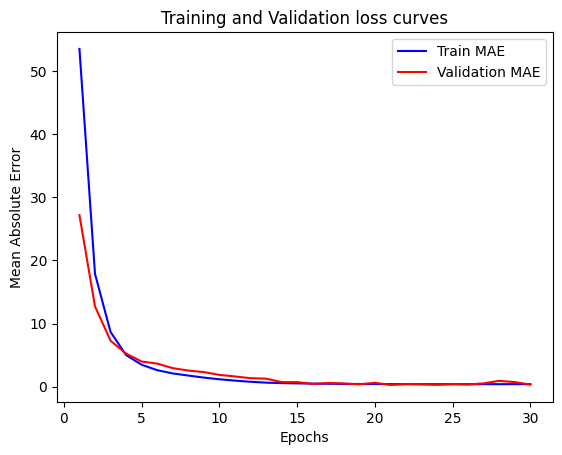

In [33]:
train_loss = GRU_history.history['loss']
val_loss = GRU_history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Training and Validation loss curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Making predictions using the trained model
y_train_GRU = GRU_model.predict(X_train_dense)
y_val_GRU = GRU_model.predict(X_val_dense)

# Calculating the mean absolute error from the training and validation sets
mae_train_GRU = mean_absolute_error(r_train_dense, y_train_GRU)
mae_val_GRU = mean_absolute_error(r_val_dense, y_val_GRU)

# Printing the mean absolute error from the training and validation sets
print("\"Current Network throuput\" baseline:\n train mae = ", mae_train_GRU,
      "\n validation mae = ", mae_val_GRU)

# Printing the shapes of the predicted output from the training and val sets
print(y_train_GRU.shape)
print(y_val_GRU.shape)


37/37 [==============================] - 0s 4ms/step
"Current Network throuput" baseline:
 train mae =  0.106271364 
 validation mae =  0.08672168
(4693, 1)
(1164, 1)


**Results on the test set, chenking how our trained model performs on new data**

In [35]:
X_train_all_dense,r_train_all_dense = create_dataset_windowed(train_all_scaled,train_all_labels)
X_train_all_dense = np.squeeze(X_train_all_dense)
X_test_dense,r_test_dense = create_dataset_windowed(test_scaled,test_labels)
X_test_dense = np.squeeze(X_test_dense)

print(X_train_all_dense.shape)
print(r_train_all_dense.shape)
print(X_test_dense.shape)
print(r_test_dense.shape)

(5865, 3)
(5865,)
(1163, 3)
(1163,)


In [36]:
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [37]:
# Creating our LSTM
from keras.callbacks import LearningRateScheduler
def create_model_test(input_shape):

    # Initializing the Sequential model
    modelLSTM = Sequential()
    # Adding layers to the model
    modelLSTM.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    modelLSTM.add(BatchNormalization())
    modelLSTM.add(Dropout(0.5))

    modelLSTM.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    modelLSTM.add(BatchNormalization())
    modelLSTM.add(Dropout(0.5))

    modelLSTM.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    modelLSTM.add(BatchNormalization())
    modelLSTM.add(Dropout(0.5))

    modelLSTM.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    modelLSTM.add(BatchNormalization())
    modelLSTM.add(Dropout(0.5))

    modelLSTM.add(Dense(1, activation='linear'))

    # Compiling the model
    modelLSTM.compile(optimizer=Nadam(lr=0.0001), loss='mae')

    # Returning the model
    return modelLSTM

In [39]:
LSTM_model_test = create_model_test((3,1))
LSTM_model_test.summary()
LSTM_history_test = LSTM_model_test.fit(X_train_all_dense, r_train_all_dense, epochs=30, batch_size=64, validation_data=(X_test_dense, r_test_dense))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 3, 1024)           2105344   
 onal)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 3, 1024)           4096      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 3, 1024)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 3, 512)            2623488   
 ional)                                                          
                                                                 
 batch_normalization_13 (Ba  (None, 3, 512)            2048      
 tchNormalization)                                    

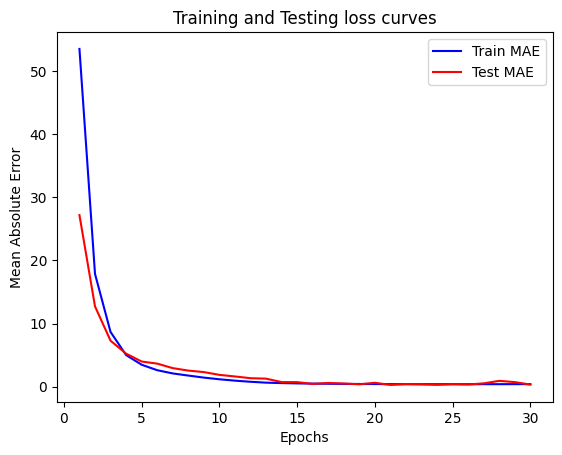

In [40]:
train_all_loss = LSTM_history_test.history['loss']
test_loss = LSTM_history_test.history['val_loss']

# Plotting the training and test loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train MAE')
plt.plot(epochs, val_loss, 'r', label='Test MAE')
plt.title('Training and Testing loss curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

37/37 [==============================] - 0s 4ms/step
"Current Network throuput" baseline:
 train_all mae =  0.2342884 
 test mae =  0.39594865
(5865, 1)
(1163, 1)


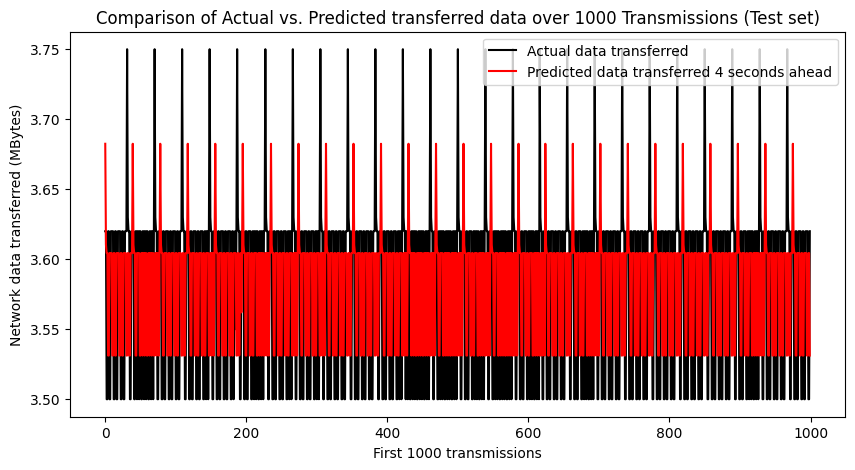

In [41]:
y_train_all_LSTM = LSTM_model_test.predict(X_train_all_dense)
y_test_LSTM = LSTM_model_test.predict(X_test_dense)

# Calculating the mean absolute error from the training and validation sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_dense, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_dense, y_test_LSTM)

# Printing the mean absolute error from the training and test sets
print("\"Current Network throuput\" baseline:\n train_all mae = ", mae_train_all_LSTM,
      "\n test mae = ", mae_test_LSTM)

# Printing the shapes of the predicted output from the training and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

# Visualising first 1000 predictions from the Test set
def scale_predictions_to_labels(labels, predictions):
    scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions * scale_factor
    return scaled_predictions

# Apply the scaling function
scaled_predictions = scale_predictions_to_labels(r_test_dense[:1000], y_test_LSTM[:1000, 0])

# Now plot the labels and scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(r_test_dense[:1000], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:1000], 'r-', label='Predicted data transferred 4 seconds ahead')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 1000 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 1000 Transmissions (Test set)')
plt.legend()
plt.show()